In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
os.chdir('/content/drive/MyDrive/datasets/models/c8v4')

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

(60000, 28, 28)


In [ ]:
tf.shape(train_images)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([60000,    28,    28,     1], dtype=int32)>

In [ ]:
def create_generator():
    model = tf.keras.Sequential()
    
    # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
    model.add(layers.Dense(7*7, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(7*7*4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 4)))

    model.add(layers.Conv2DTranspose(32, 3, strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


In [ ]:
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49)                4900      
                                                                 
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 49)                0         
                                                                 
 dense_1 (Dense)             (None, 196)               9604      
                                                                 
 batch_normalization_1 (Batc  (None, 196)              784       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 196)               0

In [ ]:

def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1], activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))

    return model

In [ ]:
d=create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         204928    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)             

In [ ]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:

noise_dim = 100
num_of_generated_examples = 16

seed = tf.random.normal([num_of_generated_examples, noise_dim])

In [ ]:
generator = create_generator()
discriminator = create_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([32, noise_dim])

    global generator, discriminator
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = G_loss(fake_output)
      disc_loss = D_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) 

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
from tqdm import tqdm

def train_GAN(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # noise= np.random.normal(loc=0, scale=1, size=[examples, 64])
    noise = tf.random.normal([100, noise_dim])
    generated_images = generator.predict(noise)
    # generated_images = generated_images.reshape(100,28,28)
    dim=(10,10)
    figsize=(10,10)
    plt.figure(figsize=figsize)
    # plt.figure()
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i].reshape(28, 28), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [ ]:
train_GAN(train_dataset, 100)

In [ ]:
generator.save('generator4.h5')

In [ ]:
discriminator.save('discriminator4.h5')

In [ ]:
g = tf.keras.models.load_model('generator4.h5')

In [ ]:
g.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 49)                4900      
                                                                 
 batch_normalization_6 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 49)                0         
                                                                 
 dense_5 (Dense)             (None, 196)               9604      
                                                                 
 batch_normalization_7 (Batc  (None, 196)              784       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 196)              

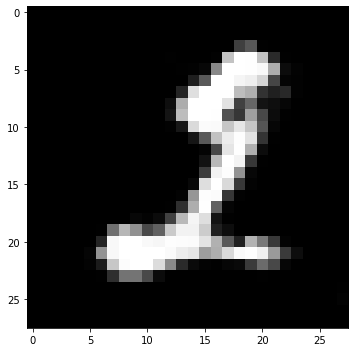

In [ ]:
noise = tf.random.normal([1, noise_dim])
generated_images = g.predict(noise)
# generated_images = generated_images.reshape(100,28,28)
dim=(10,10)
figsize=(5,5)
plt.figure(figsize=figsize)
# plt.figure()
# for i in range(generated_images.shape[0]):
#     plt.subplot(dim[0], dim[1], i+1)
#     plt.imshow(generated_images[i].reshape(28, 28), interpolation='nearest', cmap='gray')
#     plt.axis('off')
plt.imshow(generated_images.reshape(28, 28), interpolation='nearest', cmap='gray')
plt.tight_layout()
# plt.savefig('gan_generated_image %d.png' %epoch)

In [ ]:
d = tf.keras.models.load_model('../c8v1/discriminator1.h5')
d.summary()

In [ ]:
d.predict(generated_images)

array([[-0.28663963]], dtype=float32)